In [1]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import datetime
import matplotlib.pyplot as plt
import numpy
from readSelfTrackerSheet import *
import difflib

In [2]:
sheet = RetrieveSpreadSheet()

In [3]:
 SetUpDates()

Please provide the begin date in "M/D/YYYY" format (ie 5/11/1989) to filter
	"all"	if you dont want to filter:all


In [4]:
GetListOfTraineeObjects(sheet)

Please indicate in semicolon seperated format who the desired trainees are.

	ie "Gamboa,Allan"; "Basior,Greg";...

	If all trainees are desired say:

	"all"

	Available Trainees are:

	Curnutt
	Rowlett
	Frye
	Helwig
	Griffin
	Garvey
	Pittman
	Perkins
	Warner
	Jestes
	Vaughan
all
Creating Object For curnutt
Creating Object For rowlett
Creating Object For frye
Creating Object For helwig
Creating Object For griffin
Creating Object For garvey
Creating Object For pittman
Creating Object For perkins
Creating Object For warner
Creating Object For jestes
Creating Object For vaughan


In [5]:
FilterTraineesDateRanges()

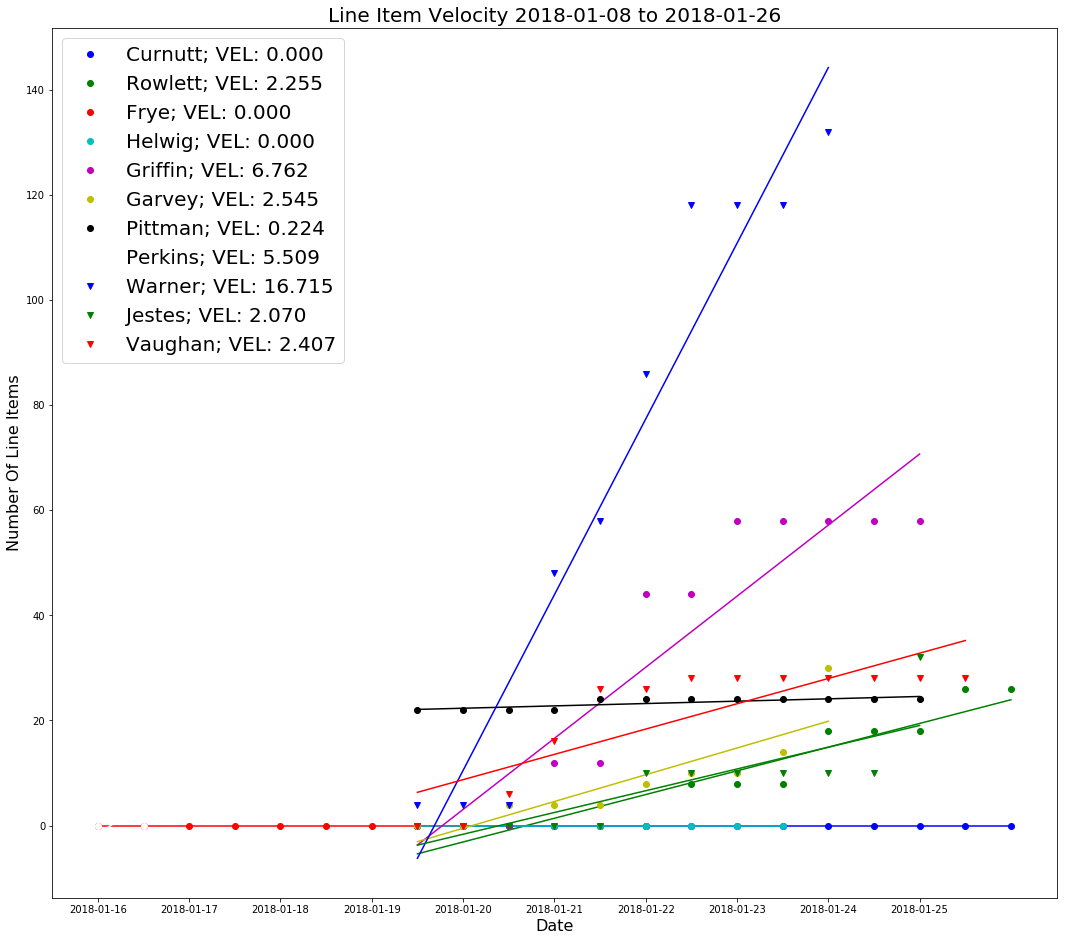

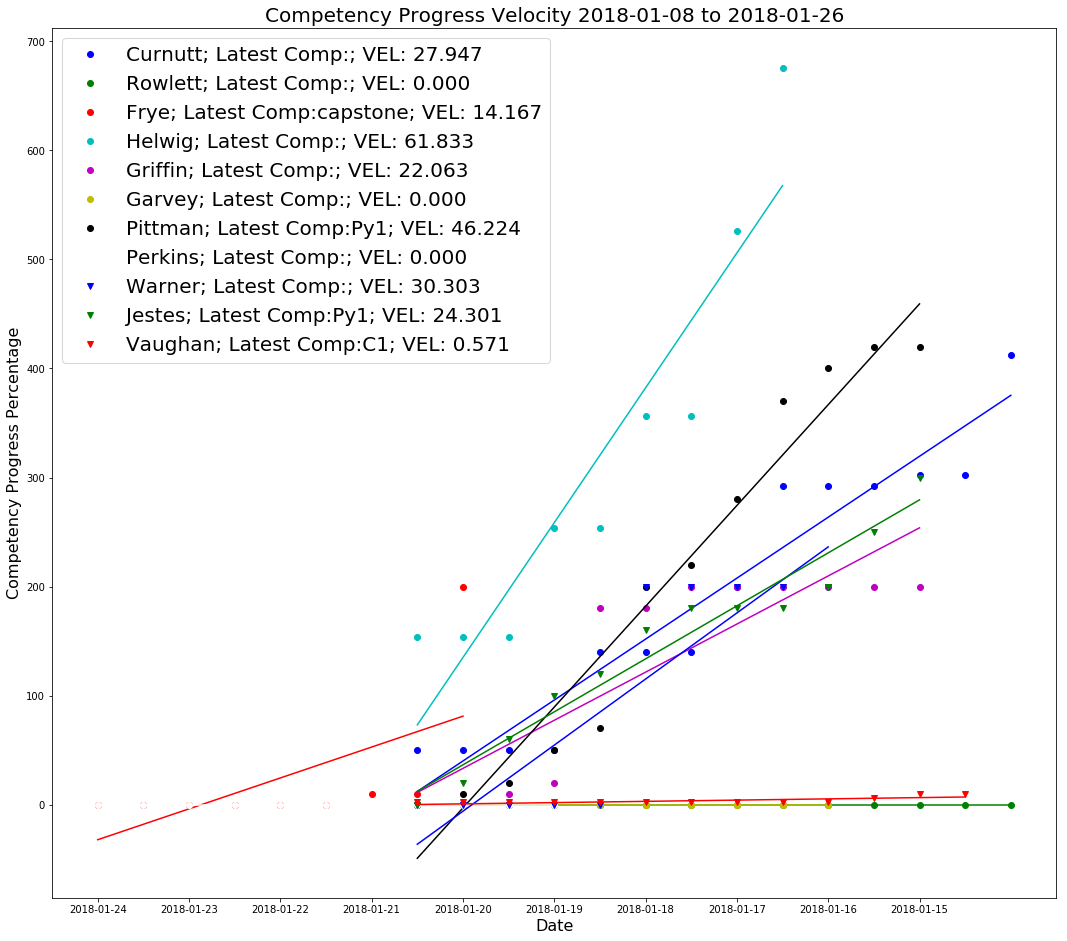

In [6]:
MakePlots()
   

In [7]:
CreateTableOfVelocities()

2018-01-08 to 2018-01-26
Line Velocity ML:	Mean = 3.499	STD = 4.695
Comp Velocity ML:	Mean = 20.674	STD = 19.624
Line Velocity AVG:	Mean = 1.541	STD = 1.776
Comp Velocity AVG:	Mean = 10.191	STD = 10.618

      NAME          LINE ITEM       LINE ITEM     COMP PROGRESS   COMP PROGRESS    LINE ITEMS         COMPS     
                  VELOCITY ML    VELOCITY AVG    VELOCITYM ML    VELOCITY AVG      COMPLETED       COMPLETED   
    Curnutt          0.000           0.000           27.947          14.714            0               1       
    Rowlett          2.255           0.929           0.000           0.000            13               0       
     Frye            0.000           0.000           14.167          11.111            0               1       
    Helwig           0.000           0.000           61.833          37.556            0               0       
    Griffin          6.762           2.417           22.063          8.333            29               1       
    Garvey 

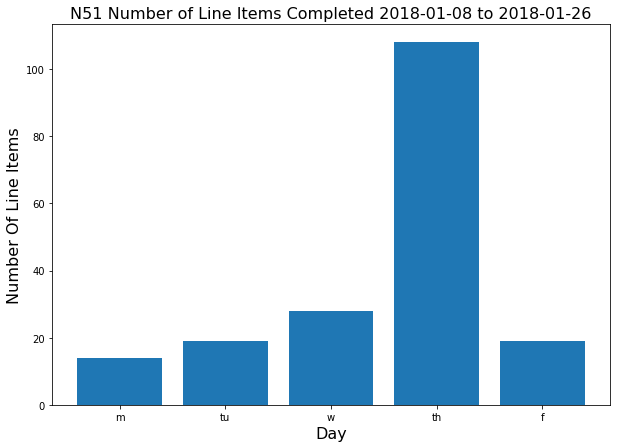

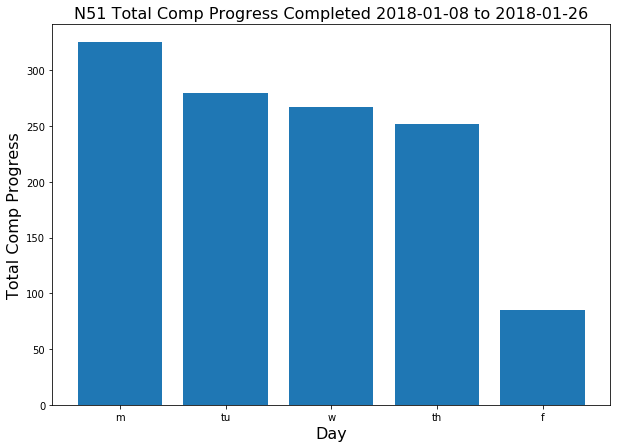

In [8]:
CreateDayOfWeekDistributions()

In [ ]:
UpdateJQRTracker(selfTrackerSheetName='JQR Self Progress',
                     historicalTrackerSheetName='Historical Training Tracker',
                     targetSheetName='Training Tracker.xlsx')